# Support Vector Machine (SVM)

This tutorial features the Support Vector Machine (SVM) technique for classifying riverbed morphology types as a function of hydraulic and sediment transport data.

```{admonition} Goals
+ Pre-process a dataset containing hydrodynamic measurements and five river bed morphology classes according to {cite:t}`montgomery_channel-reach_1997`.
+ Use Variance Inflation Index (VIF) to evaluate Multicollinearity among features.
+ Train and test a Support Vector Machine (SVM) model to classify river bed morphology using a Radial Basis Function (RBF) kernel.
```

```{admonition} Requirements
:class: attention

Read and understand data handling with {ref}`numpy`, {ref}`pandas`, {ref}`matplotlib`, and {ref}`functions <chpt-functions>`. We assume that you are familiar with basic statistic parameters, such as Gaussian probability distributions, their mean, and their standard deviation values.
```

Enable interactive reading and executing code blocks with [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/hydro-informatics/jupyter-python-course/main) and find *morphology-predictor-svm.ipynb* Alternatively, install {ref}`Python <install-python>` and {ref}`JupyterLab <jupyter>` locally and **[download](https://github.com/ricardovobarros/hydro-informatics/tree/main/morphology_predictor)** this Jupyter notebook.

## Theory

In the field of restoration science, the identification of river morphology provides essential insights, for instance, to guide target terraforming aiming at re-instating a near-census natural state of a fluvial landscape. In addition, morphological pattern may serve as a predictor for estimating fluvial {term}`sediment transport <Sediment transport>` and vice versa. Thus, there is a bidirectional relationship between fluvial hydraulics, sediment transport, and morphological pattern, which represent physical habitat for aquatic species and may even affect energy production {cite:p}`recking2016quantifying`.

Yet, classifying and predicting fluvial morphodynamics is challenging because of the complexity of river ecosystems and every river being a unique environment. However,there are repeating morphological units of rivers with similar characteristics. A basic set of repetitive morphological features was introduced by {cite:t}`montgomery_channel-reach_1997`, and we will focus in this tutorial on the following five morphological units (click on the items to read more):

+ **{term}`Step pool`** 
+ **{term}`Plane bed`**
+ **{term}`Riffle pool`**
+ **{term}`Braiding`**
+ **{term}`Sand bed`**

These morphological units can be found in the above-listed order along a river, starting at the source and ending with its estuary. Thus, *step pool* units can typically be found in upstream (mountain) river section, while *sand beds* are predominantly existent in shallower river sections, close to estuaries or confluences. Note that there are many other morphological units besides, such as slackwater, swales, or bars {cite:p}`wyrick_geospatial_2014`. Fig. {numref}`fig-bed-morphology` illustrates some morphological units of near-census natural rivers.

```{figure} ../img/nature/morphology-overview.jpg
  :alt: riverbed morphologies
  :name: fig-bed-morphology


  a) A colluvial headwater stream (Furtschaglbach, Austria), b) a cascade stream (Torrent des Favrands, France), c) a bedrock stream (Anse St-Jean, Québec, Canada), d) a step-pool stream (Dessoubre, France), e) a plane-bed stream (Dranse, Switzerland), f) a riffle-pool stream (Le diable, Québec, Canada), g) a braided stream (Jenbach, Germany). Source: {cite:t}`schwindt_hydro-morphological_2017`
```

To guide restoration actions, experts often visually classify morphology units on-site, though some of them may also be distinguishable on aerial imagery. On-site (*in-situ*) expert assessments may also serve as ground truth for machine learning models. In this exercise, we will use hydrodynamic parameters with expert-based ground truth from the database [https://bedloadweb.com](https://en.bedloadweb.com/). Thus, at the end of this tutorial, you may be able to reduce a necessary amount of fieldwork, just by using hydraulic parameters that can sometimes also be retrieved from gauging stations. To this end, we will train and test an SVM model that classifies morphological units as a function of data that can be collected *in-situ* or derived from aerial imagery. 

# Pre-processing

## Load Data

We downloaded a dataset from [https://bedloadweb.com](https://en.bedloadweb.com/) ([download the *bedload_dataset*](https://raw.githubusercontent.com/hydro-informatics/jupyter-python-course/main/data/bedload_dataset) sample): 

+ Every sample is derived from the cross-sections of 146 different rivers around the globe.
+ The dataset is embraces hydraulic and sediment transport (e.g., grain sizes) though in this tutorial, we will only use the following parameters to train the SVM model:
    + **W**: Channel width (m)
    + **S**: Channel slope (m)
    + **Q**: Discharge (m$^3$ s$^{-1}$)
    + **U**: Bulk flow velocity (m s$^{-1}$)
    + **H**: Water depth (m)

In a machine learning context, **these parameters** for predicting morphological units **are also called features**. The first step is to load (and view) the data as a `pandas.DataFrame`:

In [1]:
import pandas as pd

data= pd.read_csv("data/bedload_dataset")
data

,W,S,Q,U,H,Morphology
0,65.23,0.004100,319.98,2.90,1.69,Riffle-pool
1,3.30,0.018000,1.08,1.00,0.32,Riffle-pool
2,7.00,0.001500,3.96,0.73,0.78,Riffle-pool
3,166.12,0.000680,1124.18,1.78,3.81,Riffle-pool
4,8.38,0.013018,2.50,0.83,0.38,Riffle-pool
...,...,...,...,...,...,...
1062,102.00,0.000960,171.00,1.40,1.20,Braiding
1063,8.40,0.025000,3.34,1.20,0.33,Braiding
1064,101.00,0.000440,260.00,1.50,1.80,Braiding
1065,7.50,0.025000,2.15,0.96,0.30,Braiding


## Clean the Dataset

To avoid the SVM model being affected by statics made based on nonsense entries (e.g., Not-a-Number **NaN**) values or extreme outliers, for instance, resulting from typos, we will make apply some cleaning methods.

### Remove NaN Values

The first cleaning step is to remove *NaN*s that may lead the SVM model later to making bad conclusions.

In [2]:
# dataset essencial info
print(data.info(),"\n")
    
# remove rows that contains at least one NaN value
print(data.dropna(inplace=True))

# verify that all NaN values were removed
for column in data.columns.to_list():
    print(column,":",data[column].isnull().any())
    
# verify final shape of the dataset  
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   W           1067 non-null   float64
 1   S           1067 non-null   float64
 2   Q           1067 non-null   float64
 3   U           1067 non-null   float64
 4   H           1067 non-null   float64
 5   Morphology  1067 non-null   object 
dtypes: float64(5), object(1)
memory usage: 50.1+ KB
None 

None
W : False
S : False
Q : False
U : False
H : False
Morphology : False
(1067, 6)


### Search Outliers

Outliers may occur in extreme environment or under extreme conditions (e.g., intense precipitation), but some of them also stem from equipment failures that will affect the performance of the SVM model. Thus, recognizing and removing such device-related outliers is an essential step.

Visualizing the plotted features in a scatter plot can be helpful to spot outliers candidates. The following code block creates scatter plots of every feature, marks the expected value, and the distance of 2 standard deviations (assuming a Gaussian-like distribution) from it.

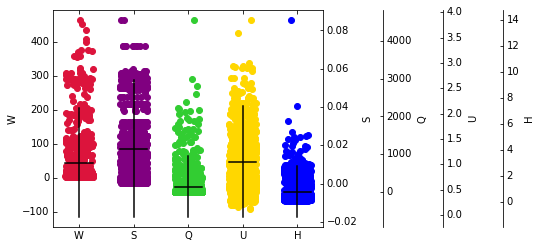

In [3]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import numpy as np
import matplotlib.pyplot as plt

# visualize scatter of the features 
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

# plot visualization parameters
labels = data.columns[0:5].tolist()
colors = ["crimson", "purple", "limegreen", "gold", "blue"]
width=0.5

# iterate on features of the dataset (i.e. column names)
for i, l in enumerate(labels):
    if i ==0:
        ax = host
        ax.set_ylabel(labels[i])
    else:        
        ax = host.twinx()
        new_fixed_axis = ax.get_grid_helper().new_fixed_axis
        ax.axis["right"] = new_fixed_axis(loc="right",
                                            axes=ax,
                                            offset=(60*(i-1), 0))
        ax.axis["right"].toggle(all=True)
        ax.set_ylabel(labels[i])

    x = np.ones(data.shape[0])*i + (np.random.rand(data.shape[0])*width-width/2.)
    ax.scatter(x, data[data.columns[i]],color=colors[i])
    mean = data[f"{data.columns[i]}"].mean()
    std = np.std(data[data.columns[i]])
    ax.plot([i-width/2., i+width/2.], [mean, mean], color="k")
    ax.plot([i,i], [mean-2*std, mean+2*std], color="k")

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

plt.draw()
plt.show()

### Remove Outliers

Outliers can be removed with two different methods:

1. Manual (i.e., expert judgment): identify outliers of the features and remove them by setting limits of their interval.
2. Automated: assume a probability distribution and set limits based on low probability of observation occurrence.

```{admonition} Warning
:class: warning

The automated method is more prone to deleting real, extreme observations. So pay attention in practice!
```

The following code blocks implements these two options (manual-expert and automated) methods. The manual outlier removal is _hard coded_ because the limits should be given by experts. 

The automated approach (below else statement) assumes the data having a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution), where points with a so-called [z-score](https://en.wikipedia.org/wiki/Standard_score) greater than 4 (four) are removed. Data points with a z-score less or equal to four have a 99.9%-chance of being inside an interval of four standard deviations away from the expected value. Thus, a sample that has a 0.01%-chance of occurrence is considered automatically an outlier and removed from the dataset. Thus, in this case, the z-score represents the standard deviation, and we use the `zscore` function of the `scipy` library.

In [4]:
from scipy.stats import zscore
# choose the method to remove outliers
# remove_method = "expert_analysis"
remove_method = "zscore"

if "expert" in remove_method:
    data = data.loc[(data["qs"]<0.02) &
                    (data["Q"]<2000) &
                    (data["W"]<250)]
else:
    data = data[(np.abs(zscore(data.loc[:,data.columns!="Morphology"])) < 4).all(axis=1)]
    
data

,W,S,Q,U,H,Morphology
0,65.23,0.004100,319.98,2.90,1.69,Riffle-pool
1,3.30,0.018000,1.08,1.00,0.32,Riffle-pool
2,7.00,0.001500,3.96,0.73,0.78,Riffle-pool
3,166.12,0.000680,1124.18,1.78,3.81,Riffle-pool
4,8.38,0.013018,2.50,0.83,0.38,Riffle-pool
...,...,...,...,...,...,...
1062,102.00,0.000960,171.00,1.40,1.20,Braiding
1063,8.40,0.025000,3.34,1.20,0.33,Braiding
1064,101.00,0.000440,260.00,1.50,1.80,Braiding
1065,7.50,0.025000,2.15,0.96,0.30,Braiding


## Verify Class Proportions

A machine learning model requires the ground truth data to comply with some quality standard. Those involve (among others): 

+ Every combination of models needs a different minimum number of samples to have [statistical significance](https://en.wikipedia.org/wiki/Statistical_significance). It is not a trivial task to identify the minimum number of samples that yield a trustworthy model. However, to represent a class properly (whatever that means), the so-called [frequency distribution](https://www.investopedia.com/terms/f/frequencydistribution.asp#:~:text=A%20frequency%20distribution%20is%20a,observations%20within%20a%20given%20interval.&text=The%20intervals%20must%20be%20mutually,used%20within%20a%20statistical%20context.) of every feature must be similar to the [population](https://www.bmj.com/about-bmj/resources-readers/publications/statistics-square-one/3-populations-and-samples) frequency distribution.
+ Having more than [30 samples](https://math.stackexchange.com/questions/1287990/estimating-population-standard-deviation-with-sample-standard-deviation) when dealing with normally distributed variables is a good-practice rule of thumb.
+ Ideally, the classes used for a classification problem should be represented by a similar quantity of samples. An unbalanced dataset may produce a model that gives preference to classifying correctly the class with a larger number of samples. This is a consequence of using accuracy as a performance metric. Accuracy is the ratio of correct and the total number of predictions ($accuracy =  n_{correct\_prediction}/ n_{of\_samples}$). By preferencing the total number of correct predictions over a balanced one, accuracy masks the importance of getting the under-represented classes correctly.
+ Solutions for balancing unbalanced samples embrace:
    + Collecting or generating new data (e.g., [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) methods). If available, [precision](https://en.wikipedia.org/wiki/Precision_and_recall) is preferable for measuring model peformance (instead of accuracy).
    + [Weighting](https://www.kdnuggets.com/2019/11/machine-learning-what-why-how-weighting.html) class features, which means to assign weights to increase the importance of under-represented classes correctly. In classification problems, testing different combinations of weight yield an [ROC curve](https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/#:~:text=Like%20I%20said%20before%2C%20the,the%20One%20vs%20All%20technique.), which shows the effect of varying weights on model performance.

In this tutorial, the samples can be considered balanced, except for the sand bed class (see output below). Weighting and ROC curves are not considered here. If sensitivity and specification of the sand bed class were acceptable when classifying test data, the model could also be used for sand bed classification without the need for using balancing techniques. 

In [5]:
data["Morphology"].value_counts()

Step-pool      247
Plane Bed      243
Riffle-pool    241
Braiding       228
Sand bed        79
Name: Morphology, dtype: int64

## Derive New Predictors

Sometimes it is possible to compute new meaningful features from the existing ones. For instance, known predictors for morphology are:

+ the product of (energy) slope $S$ (-), bulk flow velocity $U$ (m/s), and water depth $H$ (m), which basically represents {term}`shear stress <Dimensionless bed shear stress>`
+ the ratio of discharge $Q$ (m$^3$/s) and width $W$ (m) (i.e., Q/W)

```{warning}
Deriving new features from existing ones through simple operations may introduce spurious correlation, which results in unreliable models.
```

In [6]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# compute new columns for the new features SUH and Q/W
data["SUH"] = (data.loc[:,"S"]*data.loc[:,"U"]*data.loc[:,"H"])
data["Q/W"] = (data.loc[:,"Q"]/data.loc[:,"W"])
data

,W,S,Q,U,H,Morphology,SUH,Q/W
0,65.23,0.004100,319.98,2.90,1.69,Riffle-pool,0.020094,4.905412
1,3.30,0.018000,1.08,1.00,0.32,Riffle-pool,0.005760,0.327273
2,7.00,0.001500,3.96,0.73,0.78,Riffle-pool,0.000854,0.565714
3,166.12,0.000680,1124.18,1.78,3.81,Riffle-pool,0.004612,6.767277
4,8.38,0.013018,2.50,0.83,0.38,Riffle-pool,0.004106,0.298329
...,...,...,...,...,...,...,...,...
1062,102.00,0.000960,171.00,1.40,1.20,Braiding,0.001613,1.676471
1063,8.40,0.025000,3.34,1.20,0.33,Braiding,0.009900,0.397619
1064,101.00,0.000440,260.00,1.50,1.80,Braiding,0.001188,2.574257
1065,7.50,0.025000,2.15,0.96,0.30,Braiding,0.007200,0.286667


## Verify Multicolinearity

Correlated features (i.e., statistically dependent measurement parameters) may result in unreliable models. For instance, consider a scientist who wants to use machine learning (ML) models to predict the number of tourists that get sun-burned in Brazil during their vacation. She wants to use solar radiation intensity and the number of icecream scoops sold as features. The scientist may find that both features are relevant to predict the number of sun-burned tourist, but the reason for this finding is that the number of icecream scoops sold, and sun intensity are correlated. Thus, the scientist has no way to know what is the real importance of each feature in predicting sun-burned tourists because the features grow and decrease simultaneously. By the way, icecream consumption and sun burns have no causality in common, but that is another subject. 

To this end, it is important to investigate the correlation among features and consider eliminating the correlated features to produce a more reliable model. One way to visually spot colinearity is plotting the combination of two variables in a scatter plot. For this purpose, the below figure aids in spotting the following aspects of the `bedload_dataset`:

+ There is a strong linear correlation between the $H$ and $Q/W$ features.
+ There is no linear correlation between $W$ and $U$.
+ The flow velocity $U$ distribuiton is approximately normal (see main diagonal).

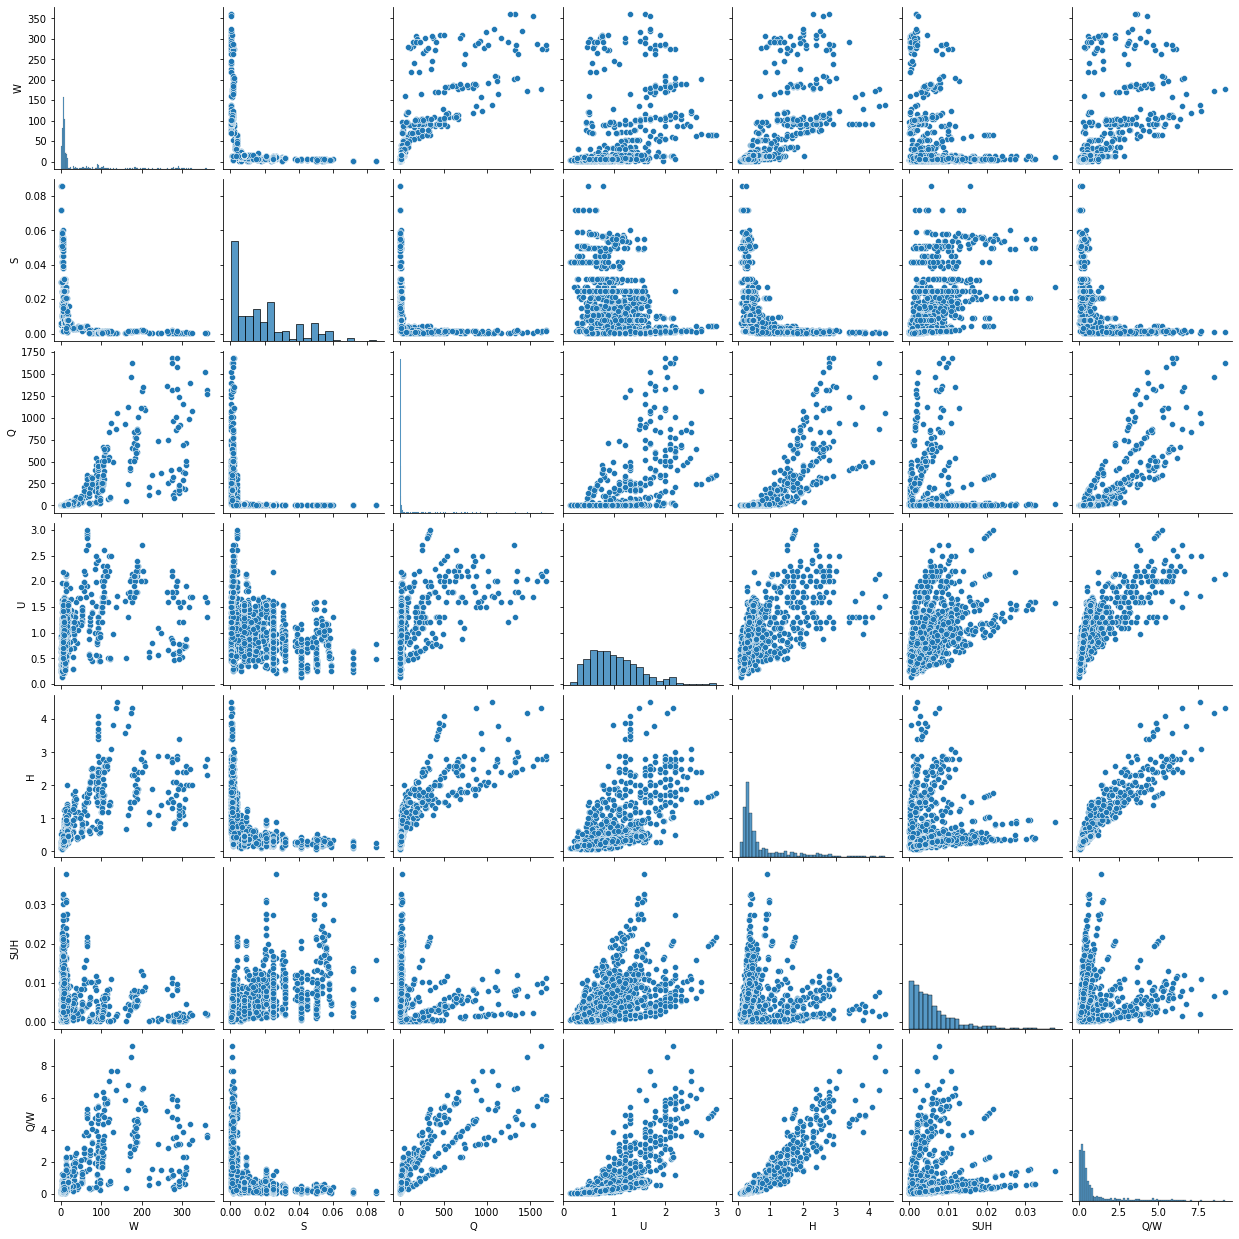

In [7]:
import seaborn as sns

# plot scatter of the 2d (two dimensinal) combination of features
sns.pairplot(data.loc[:,data.columns!="Morphology"])
plt.show()

In addition, a [heatmap](https://en.wikipedia.org/wiki/Heat_map#:~:text=A%20heat%20map%20) is another efficient method to visualize linear correlation among features. Also computing [linear correlation](https://en.wikiversity.org/wiki/Correlation#:~:text=Linear%20correlation%20refers%20to%20straight,late%2019th%20century%5B1%5D.) enables quantitative analysis.

<AxesSubplot:>

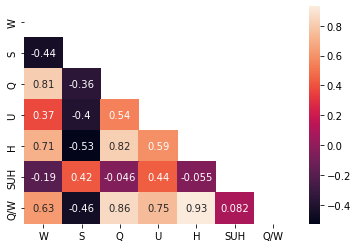

In [8]:
from seaborn import heatmap

# verify linear coorralation 
feature_corr_df = data.loc[:,data.columns!="Morphology"].corr()
mask = np.zeros_like(feature_corr_df) 
mask[np.triu_indices_from(mask)] = True
sns.heatmap(feature_corr_df, 
            annot=True, # print value inside the grid
            mask=mask # mask values (boolean matrix)
           )

## Variance Inflation Factor (VIF)

A straightforward method to evaluate [multicollinerity](https://towardsdatascience.com/statistics-in-python-collinearity-and-multicollinearity-4cc4dcd82b3f) is computing the Variance Inflation Factor (**VIF**) for every feature, which quantifies the correlation among features. 

The first step to compute the VIF is treating a feature as a [dependent variable](https://www.scribbr.com/methodology/independent-and-dependent-variables/#:~:text=The%20independent%20variable%20is%20the,changes%20in%20the%20independent%20variable.) and fit a [linear regression model](https://www.youtube.com/watch?v=nk2CQITm_eo) using the other features as [independent variable](https://www.scribbr.com/methodology/independent-and-dependent-variables/#:~:text=The%20independent%20variable%20is%20the,changes%20in%20the%20independent%20variable.). Second, store the corresponding mean square errors $MSE$ yielded by the linear model. 

Finally, VIF can be computed for each feature by the following equation: 

$$
VIF_{feature(n)} = 1/(1-MSE^2_{feature(n)})
$$

+ $VIF_{feature(n)}$ is the variance inflation factor of the $n_{th}$ feature, and 
+ $MSE^2_{feature(n)}$ is the mean square error resulting from the linear regression of the $n_{th}$ feature.


Note that the smaller the MSE (better linear regression model), the greater is the inflation. In other words, large VIF values indicate high correlation of the feature under consideration with _at least_ one of the other features. Still, it is not possible to say based on VIF only, which _other feature_ is causing VIF to inflate.

As rule of thumb, a VIF greater than 10 (ten) indicates an unsuitable set of features to produce a reliable ML model. Ideally, the VIF should remain smaller than 5 (five), which is considered moderate correlation {cite:p}`franke2010multicollinearity`. However, these reference values are not a generally and always applicable rule. VIF equal to or greater than 10 can still yield a good model. 

Further analysis to study the impact of a high VIF on correlated features can be carried out by removing each feature at a time and investigate how the feature removal affects the variation of the [standard error](https://en.wikipedia.org/wiki/Standard_error) and [p-value](https://www.youtube.com/watch?v=Cba9LJ9lS8s&t=53s) of the model.

In this tutorial, 2 features have a VIF $> $10 (notably, $H$ and $Q/W$), as the following code block shows.

In [9]:
from sklearn.linear_model import LinearRegression

# compute VIF for the features
def calculate_vif(df, features):
    vif, tolerance = {}, {}
    
    for feature in features:        
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]
        X, y = df[X], df[feature]
        
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)

        # compute VIF
        vif[feature] = 1 / (1 - r2)
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif})

# call fuction calculate_vif with features as input
calculate_vif(df=data, 
              features=data.columns[data.columns != "Morphology"].to_list())

,VIF
H,14.721236
Q,9.278038
Q/W,27.648327
S,2.983335
SUH,3.028896
U,6.515027
W,4.691707


## Remove Features to Reduce VIF

With the goal of reducing the feature VIFs to less than 5, we use a trial-and-error approach in this tutorial. Modifying the below code block shows that removing $H$ and $Q$ is enough to reduce the VIFs of the remaining features to less than 5. In particular, these two removed variables also go into above-introduced features $Q/W$ and $SUH$. Thus, although $H$ and $Q$ are removed, they still "contribute information" to the final model. 

Combining correlated features to procduce a new one, and later removing them, is a common approach to reduce VIFs. Since we yielded good VIF values by removing some of the features, no further analysis is necessary.

```{admonition} Principal Component Analysis (PCA)
Alternatively, a [Principal Component Analysis (PCA)](https://www.youtube.com/watch?v=FgakZw6K1QQ) is an effective method for reducing dimensionality (i.e., the number of dataset features going into a model) to increase the reliability of a model, and at the same time, minimize information loss.
```

Finally, the features that are used to train and test the SVM model are shown by the output of the code block below.

In [10]:
# try and error approach removing features get VIFs < 10 
data = data.loc[:, data.columns[(data.columns !="H")&
                                (data.columns !="Q")
                               ]
               ]

# compute VIF again to verify if VIFs are less than 5
calculate_vif(df=data, 
              features=data.columns[data.columns != "Morphology"].to_list())

,VIF
Q/W,3.628840
S,2.451387
SUH,2.855595
U,4.778947
W,1.872494


## Split Test and Training Datasets
The last preparation step for building the SVM model is to derive a training and a testing dataset from the entire `bedload_dataset`. Choosing a share for data to compose a training and a testing dataset is commonly a heuristic choice. Here,  we use 33% of the data for testing a final hypothesis later. Note that inside the split datasets, the index of the samples (rows of the tabular data) have their corresponding class inside the _target datasets_.

In [11]:
from sklearn.model_selection import train_test_split 


# split dataframes with features and labels only
labels = data.loc[:, "Morphology"]
predictors = data.loc[:, data.columns[data.columns != "Morphology"]]

# split testing set as 33% of the data
# X correspond to the featues (matrix form)
# y corresponf to the labels (vector form)
X_train, X_test, y_train, y_test = train_test_split(predictors,  
                                                    labels,
                                                    test_size=0.3, 
                                                    random_state=42 # seed for random selection of data
                                                   )

# visualize training and testing sets
print("TRAINING DATASET PREDICTORS")
print(X_train.head(), "\n")
print("dataframe size", X_train.shape,"\n")
print("------------------------------------------")
print("TRAINING DATASET TARGET")
print(y_train,"\n")
print()
print("------------------------------------------------------------------------------------\n")

print("TESTING DATASET PREDICTORS")
print(X_test.head())
print("dataframe size", X_test.shape,"\n")
print("------------------------------------------")
print("TESTING DATASET TARGET")
print(y_test.head())
print("Vector size", y_test.shape)


TRAINING DATASET PREDICTORS
          W        S     U       SUH       Q/W
256    6.91  0.01100  1.02  0.003366  0.277858
397   88.09  0.00210  1.99  0.008149  3.889545
586   14.02  0.02070  1.34  0.022190  1.078459
526  218.00  0.00041  0.52  0.000175  0.541284
9      8.00  0.02000  1.18  0.007316  0.370000 

dataframe size (726, 5) 

------------------------------------------
TRAINING DATASET TARGET
256      Plane Bed
397      Plane Bed
586      Step-pool
526       Sand bed
9      Riffle-pool
          ...     
89     Riffle-pool
337      Plane Bed
476      Plane Bed
123    Riffle-pool
876       Braiding
Name: Morphology, Length: 726, dtype: object 


------------------------------------------------------------------------------------

TESTING DATASET PREDICTORS
          W        S     U       SUH       Q/W
203    2.57  0.01040  1.58  0.008216  0.793774
937  105.00  0.00096  1.90  0.002918  3.076190
546   93.00  0.00050  1.10  0.001320  2.688172
214   53.04  0.00380  1.44  0.004596 

# Build the SVM Model

## Working Principle
A Support Vector Machine (SVM) is a learning algorithm that searches for a so-called **hyperplane** that optimally separates feature classes. To find an optimal separation, the algorithm tries to maximize the distance (or margin) from the hyperplane to the nearest data points. The data points near to the limits of the margin are also denominated **support vectors** because they work as a reference to _draw_ the hyperplane (see Fig. {numref}`svm-margin-morphology` below).

```{figure} ../img/datascience/svm-margin.jpg
:alt: datascience
:name: svm-margin-morphology


Illustration of a hyperplane and margins of an SVM. Source: Ricardo Barros
```

For instance, assume that two of the above classes are linearly separable. We can define the regions that contain each class by means of the following hyperplane: 

$ \vec{w}  \vec{X} + b > 1 $ --> __Class Red__, and
$ \vec{w}  \vec{X} + b < 1 $ --> __Class Blue__

where

+ $\vec{w}$ is the vector of weights, 
+ $\vec{X}$ is the matrix of features,
+ $b$ is the independent variable (also called **bias**), and 
+ the value of $1$ is chosen as a representative simplification, since $b$ can basically be any value. 

Finally (after some steps that are not discussed here), we can compute an optimal hyperplane by minimizing the following expression:

$min (0.5 \vec{w^t} \vec{w})$

where $\vec{w^t}$ is the **transposed weight vector**.

In the real world, however, it is common to find problems where classes are not linearly separable. In such situations, so-called **kernels** can be applied. A kernel is a function that transforms $\vec{X}$ to a matrix with higher dimensions by combining the available features to create new features (i.e., new dimensions). 

Here, we apply the [Radius Base Function (RBF)](https://towardsdatascience.com/radial-basis-function-rbf-kernel-the-go-to-kernel-acf0d22c798a) kernel. The RBF is a popular kernel because it transforms the $\vec{X}$ into an infinite dimension matrix without the risk of overfitting the model.

```{admonition} Get more detail..
:class: hint
+ For more details on the _SVM_  calculation procedure, visit [analyticsvidhya.com](https://www.analyticsvidhya.com/blog/2021/10/support-vector-machinessvm-a-complete-guide-for-beginners/).
+ For a complete lecture on _SVM_ (provided by the [MIT](https://mit.edu)), visit their [YouTube channel](https://www.youtube.com/watch?v=eHsErlPJWUU).
```


## k-fold Cross Validation

SVMs composed by an RBF kernel can be validated by tuning two parameters:

1. __C__: determines how much are the margins are permissive. It differentiates between a **hard margin** (i.e., a margin that enables little or no penetration of data points) and a **soft margin** (i.e., a margin that enables penetration of data points inside the margin). A higher __C__ corresponds to a harder the margin. 
2. __gamma__: determines the region of similarity among samples. It is the only variable of the RBF kernel. The higher gamma is, the broader is the influence of a labeled sample on classifying a new sample. 

Hard margins can also be interpreted as the **sensitivity of the hyperplane** when fitting it with the data. The harder the margin, the more the hyperplane twists to not allow any data point to penetrate the margin. 

In this tutorial, we define _C_ based on a try-and-error approach and a gamma stemming from a five-fold [cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/#:~:text=Cross%2Dvalidation%20is%20a%20resampling,k%2Dfold%20cross%2Dvalidation.). The following code block builds the SVM using the `sklearn` library, and prints the validation and training error curves resulting from varying _gamma_.

```{admonition} Further reading
:class: hint
For a _C_ and _gamma_ search code example, have a look into the [scikit-learn docs](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#:~:text=Intuitively%2C%20the%20gamma%20parameter%20defines,the%20model%20as%20support%20vectors.).
```


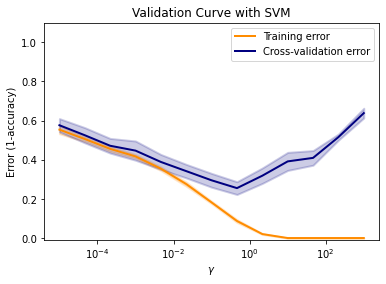

In [12]:
from sklearn.svm import SVC 
from sklearn.model_selection import validation_curve 


# define C, gamma range, kernel and number of cross-val. folds
gamma_range = np.logspace(-5, 3, 13) 
C=500  # chosen hyperparameter through tunnig
kernel = "rbf"  # radius base function
n_of_folds = 5

# Peform 5-fold cross-validation and save training and validation error
train_scores, test_scores = validation_curve(SVC(kernel=kernel, 
                                                 C=C),
                                             X_train,
                                             y_train,
                                             param_name="gamma",
                                             param_range=gamma_range,
                                             scoring="accuracy",
                                             cv=n_of_folds
                                            )

# convert accuracy into error
train_error = 1-train_scores
validation_error = 1-test_scores

# compute 5-fold cross-validation mean and std of error 
train_error_mean = np.mean(train_error, axis=1)
train_error_std = np.std(train_error, axis=1)
validation_error_mean = np.mean(validation_error, axis=1)
validation_error_std = np.std(validation_error, axis=1)

#-------------------------------------------------------------------

# visualization of training and error validation
plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Error (1-accuracy)")
plt.ylim(-0.01, 1.1)
lw = 2
plt.semilogx(
    param_range, train_error_mean, label="Training error", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_error_mean - train_error_std,
    train_error_mean + train_error_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, validation_error_mean, label="Cross-validation error", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    validation_error_mean - validation_error_std,
    validation_error_mean + validation_error_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

## Select Optimum Parameters

The decision on optimum parameters for the SVM depends on your opinion. For the purpose of selecting optimum parameters in this tutorial, the below code block quantifies the above-shown plot (in particular, the blue curve) in tabular form and saves the gamma that yields the smallest error (__gamma_opt__).

In [13]:
# save optimal gamma
index_min = min(range(len(validation_error_mean)), key=validation_error_mean.__getitem__)
validation_error_min = validation_error_mean[index_min]
gamma_opt = param_range[index_min]  # gamma that gives minimun validation error

# visualize error evolution with gamma 
columns = ["Mean validation error","gamma"]
array = np.array([validation_error_mean, param_range]).transpose()

print( pd.DataFrame(array,columns=columns), "\n")
print("Minimun mean validation error:", validation_error_min)
print("optimal gamma:", gamma_opt)

    Mean validation error        gamma
0                0.575739     0.000010
1                0.524856     0.000046
2                0.471101     0.000215
3                0.446311     0.001000
4                0.388474     0.004642
5                0.341606     0.021544
6                0.294709     0.100000
7                0.254861     0.464159
8                0.318262     2.154435
9                0.391252    10.000000
10               0.409173    46.415888
11               0.515144   215.443469
12               0.637789  1000.000000 

Minimun mean validation error: 0.2548606518658479
optimal gamma: 0.46415888336127725


## Train Optimum Hypothesis SVM Model

After defining a gamma yielding the smallest validation error (__gamma_opt__), we can train an optimal hypothesis (__h_opt__) model on the entire training dataset. In addition, we can evaluate the accuracy of the model by using it to classify the testing dataset. The below code block features the training procedure, fitting of the SVM (i.e., an optimum hypothesis), and prints the score of the optimum hypothesis.

In [14]:
# train optimal model and evaluate accuracy 
h_opt = SVC(kernel=kernel,
            gamma=gamma_opt,
            C=C) # instantiate optimal model 
h_opt.fit(X_train,y_train) # train the model with entire training set
print("Error (1-Accuracy) of h_opt on testing data: \n -->>",1- h_opt.score(X_test,y_test)) 

Error (1-Accuracy) of h_opt on testing data: 
 -->> 0.19551282051282048


## Performance Evaluation (Confusion Matrix)

Finally, the following code block generates the so-called **confusion matrix** to evaluate the optimum hypothesis model performance when classifying the samples with distinct morphologies. The confusion matrix uses the total number of samples and visualizes their true and predicted morphological units.

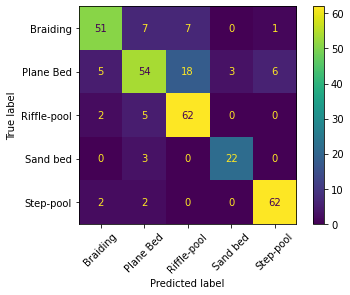

In [15]:
from sklearn.metrics import plot_confusion_matrix 

#plot confusion matrix
plot_confusion_matrix(h_opt, # trained optimal hypothesis model
                      X_test, 
                      y_test,
                     )
plt.xticks(rotation=45)
plt.show()

The confusion matrix of an exact model only has diagonal entries larger than zero, while all others are zero. Thus, the above-shown confusion matrix shows that our SVM model performs very well in predicting step-pool and riffle-pool morphologies, but unreliably predicts sand bed morphologies because of not many observations. However, the model also made wrong predictions of step-pool and riffle pool features. For instance, according to the confusion matrix, the model predicted 6 times step-pool, where in reality (true label), plane bed morphological units prevailed, and it wrongly predicted one braiding observation to be a step-pool observation. The sand bed predictions are unreliable because there are only 25 true-label sand bed observations (opposed to 66 step-pool observations). Thus, the sand bed observations are unbalanced and a solution to removing the unreliability could be to sample more sand bed morphological units (as above explained).